In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import imageio

In [61]:
# Параметры
params = {
    'mu1': 0.37, 'mu2': 0.7, 'mu3': 0.6, 'mu4': 1.48,
    'alpha': 0.73, 'beta': 0.45, 'gamma': 0.25,
    'nu1': 0.1, 'nu2': 0.1,
}
# Начальные условия
uh, ud, us, ua = 0.15, 0.03, 0.13, 0.14
t_span = [0, 1000]  # Временной интервал
intervals = np.linspace(t_span[0], t_span[1], 1000)  # Интервалы для времени

In [62]:
# Размеры сетки и параметры модели
Nx, Ny = 50, 50
dx = 0.1
D_h, D_d, D_s, D_a = 0.00007, 0.00007, 0.00007, 0.00007
# Размерность массивов
shape = (Nx, Ny)

# Генерация случайных значений и нормализация
def generate_normalized_arrays(shape):
    N_h = np.random.rand(*shape) * uh
    N_d = np.random.rand(*shape) * ud
    N_s = np.random.rand(*shape) * us
    N_a = np.random.rand(*shape) * ua

    # Нормализация так, чтобы сумма не превышала 1
    total = N_h + N_d + N_s + N_a
    N_h /= total
    N_d /= total
    N_s /= total
    N_a /= total

    return N_h, N_d, N_s, N_a

# Генерация данных
N_h, N_d, N_s, N_a = generate_normalized_arrays(shape)

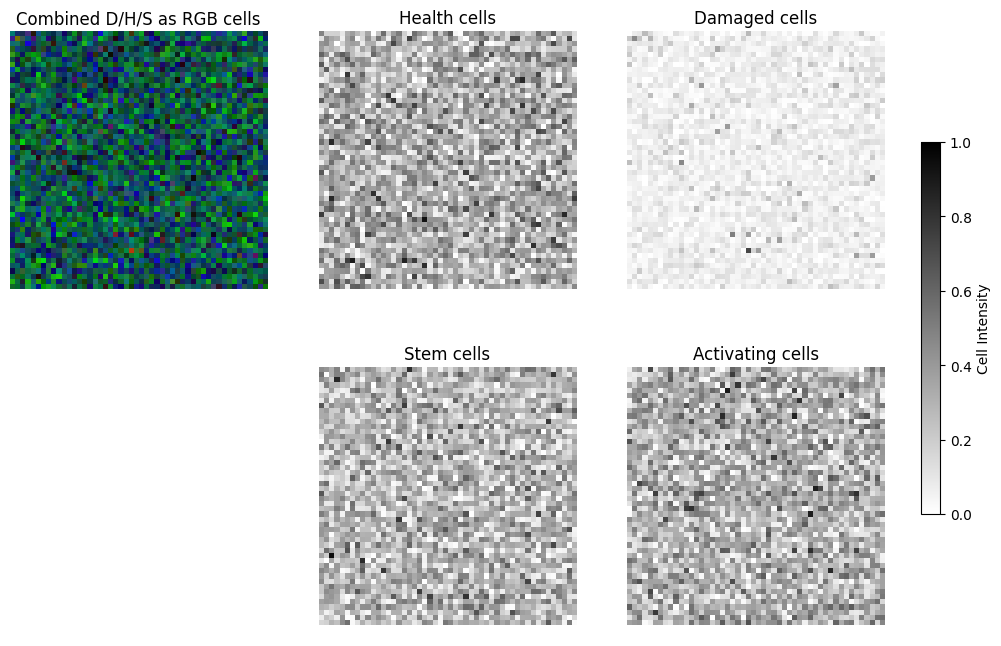

In [63]:
norm = plt.Normalize(vmin=0, vmax=1)
# Визуализация начального состояния
rgb_image = np.stack((N_d, N_h, N_s), axis=-1)
# Визуализация
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Отображаем RGB изображение и черно-белое изображение для N_a
im0 = axs[0, 0].imshow(rgb_image, norm=norm)
axs[0, 0].set_title('Combined D/H/S as RGB cells')

im1 = axs[0, 1].imshow(N_h, cmap='gray_r', norm=norm)
axs[0, 1].set_title('Health cells')

im2 = axs[0, 2].imshow(N_d, cmap='gray_r', norm=norm)
axs[0, 2].set_title('Damaged cells')

im3 = axs[1, 1].imshow(N_s, cmap='gray_r', norm=norm)
axs[1, 1].set_title('Stem cells')

im4 = axs[1, 2].imshow(N_a, cmap='gray_r', norm=norm)
axs[1, 2].set_title('Activating cells')

# Отключаем оси
for ax in axs.flat:
    ax.axis('off')

# Добавляем общий colorbar для черно-белых изображений
cbar = fig.colorbar(im4, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Cell Intensity')

plt.show()


In [64]:
def f_h(_uh, _ud, _us, _ua, _params):
    return _params['mu1'] * (1 - _uh - _ud - _us) * _uh + _params['alpha'] * _params['gamma'] * _ua * _us - _params['nu1'] * _uh

def f_d(_uh, _ud, _us, _ua, _params):
    return _params['mu2'] * (1 - _uh - _ud - _us) * _ud + (1 - _params['alpha']) * _params['gamma'] * _ua * _us - _params['nu2'] * _ud

def f_s(_uh, _ud, _us, _ua, _params):
    return _params['mu3'] * (1 - _uh - _ud - _us) * _us ** 2 - _params['gamma'] * _ua * _us

def f_a(_uh, _ud, _us, _ua, _params):
    return -_params['mu4'] * _ua * (_params['beta'] - _us)


In [65]:
def laplacian(u, dx):
    return (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
            np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) - 4*u) / dx**2

def rhs(t, y, D_h, D_d, D_s, D_a, dx, params):
    N_h = y[0:Nx*Ny].reshape((Nx, Ny))
    N_d = y[Nx*Ny:2*Nx*Ny].reshape((Nx, Ny))
    N_s = y[2*Nx*Ny:3*Nx*Ny].reshape((Nx, Ny))
    N_a = y[3*Nx*Ny:].reshape((Nx, Ny))

    dN_h = f_h(N_h, N_d, N_s, N_a, params) + D_h * laplacian(N_h, dx)
    dN_d = f_d(N_h, N_d, N_s, N_a, params) + D_d * laplacian(N_d, dx)
    dN_s = f_s(N_h, N_d, N_s, N_a, params) + D_s * laplacian(N_s, dx)
    dN_a = f_a(N_h, N_d, N_s, N_a, params) + D_a * laplacian(N_a, dx)

    return np.concatenate([dN_h.flatten(), dN_d.flatten(), dN_s.flatten(), dN_a.flatten()])


In [66]:
# Начальное состояние
y0 = np.concatenate([N_h.flatten(), N_d.flatten(), N_s.flatten(), N_a.flatten()])


# Решение системы
sol = solve_ivp(rhs, t_span, y0, args=(D_h, D_d, D_s, D_a, dx, params), method='RK45')

# Результаты
N_h_y = [sol.y[0:Nx*Ny, i].reshape((Nx, Ny)) for i in range(sol.y.shape[1])]
N_d_y = [sol.y[Nx*Ny:2*Nx*Ny, i].reshape((Nx, Ny)) for i in range(sol.y.shape[1])]
N_s_y = [sol.y[2*Nx*Ny:3*Nx*Ny, i].reshape((Nx, Ny)) for i in range(sol.y.shape[1])]
N_a_y = [sol.y[3*Nx*Ny:, i].reshape((Nx, Ny)) for i in range(sol.y.shape[1])]


In [67]:
frames = []
for i in range(len(N_h_y)):
    rgb_image = np.stack((N_d_y[i], N_h_y[i], N_s_y[i]), axis=-1)
    frames.append((rgb_image * 255).astype(np.uint8))
imageio.mimsave('cell_visualization2.gif', frames, fps=20)

![](cell_visualization.gif)

In [68]:
frames = []

for i in range(len(N_h_y)):
    
    
    norm = plt.Normalize(vmin=0, vmax=1)
    # Визуализация начального состояния
    rgb_image = np.stack((N_d_y[i], N_h_y[i], N_s_y[i]), axis=-1)
    # Визуализация
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    
    # Отображаем RGB изображение и черно-белое изображение для N_a
    im0 = axs[0, 0].imshow(rgb_image, norm=norm)
    axs[0, 0].set_title('Combined D/H/S as RGB cells')
    
    im1 = axs[0, 1].imshow(N_h_y[i], cmap='Greens', norm=norm)
    axs[0, 1].set_title('Health cells')
    
    im2 = axs[0, 2].imshow(N_d_y[i], cmap='Reds', norm=norm)
    axs[0, 2].set_title('Damaged cells')
    
    im3 = axs[1, 1].imshow(N_s_y[i], cmap='Blues', norm=norm)
    axs[1, 1].set_title('Stem cells')
    
    im4 = axs[1, 2].imshow(N_a_y[i], cmap='Oranges', norm=norm)
    axs[1, 2].set_title('Activating cells')
    
    # Отключаем оси
    for ax in axs.flat:
        ax.axis('off')
    
    # Добавляем общий colorbar для черно-белых изображений
    cbar = fig.colorbar(im4, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Cell Intensity')

    # Сохраняем текущий кадр в буфер
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(image)
    plt.close(fig)

imageio.mimsave('cell_visualization2.gif', frames, fps=5, loop=True)


C:\Users\Сергей\AppData\Local\Temp\ipykernel_30292\714597711.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
